Code based on (https://blog.keras.io/building-autoencoders-in-keras.html) By [Francois Chollet](https://twitter.com/fchollet)
# Autoencoders


![autoencoder](https://www.compthree.com/images/blog/ae/ae.png)

Usually, they are used for extracting latent representations with a lower dimensionality than the input data -> data compression 

## Case: MNIST handwritten digits

### Dataset: 

Train images: 60,000

Test images: 10,000

Image size: 28x28 pixels

![dataset](https://www.researchgate.net/profile/Steven_Young11/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset_W640.jpg)
![image of a digit](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2016/05/Examples-from-the-MNIST-dataset.png)




In [27]:
# Import MNIST dataset

from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# labels
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [28]:
# show images
import matplotlib.pyplot as plt

def see_images(dataset, n):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(dataset[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

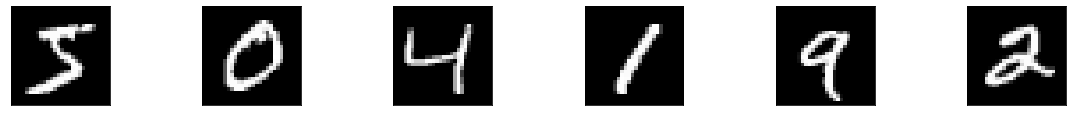

In [29]:
see_images(x_train, 6)

In [31]:
# We need to preprocess our data to use them as input in the network. 
# We normalise the images, each pixel within [0, 1] and format the images into a vector

x_train = x_train.astype('float32') / 255 # 255 max rgb value
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))

input_dim = x_train.shape[1]
x_train.shape

(60000, 784)

### Simplest autoencoder
We will use a single fully-connected neural for our encoder and decoder.

Elements:

* Input layer: $y = xI$
* Fully-connected layer: $y = xA^T + b$
* Rectified Linear Unit function: $ReLu(x)=max(0, x)$ (encoder)
* Sigmoid function: $Sigmoid(x) = \sigma(x) = \frac{1}{1+exp(-x)}$ (decoder)

![autoencoder for MNIST](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

In [32]:
from keras.layers import Input, Dense
from keras.models import Model # (template for architecture)

# latent representations dimension
latent_dim = 32
# input layer
input_img = Input(shape=(input_dim, ))
# encoder
encoder = Dense(latent_dim, activation='relu')
encoder_feats = encoder(input_img)
# decoder
decoder = Dense(input_dim, activation='sigmoid')
decoder_out = decoder(encoder_feats)

# model
simple_autoencoder = Model(input_img, decoder_out)

Before training the model, we need to set up the loss function and optimizer.
